In [ ]:
Covid19 - Europe 

In [1]:
import sys
import os
from qgis.core import *
from qgis.PyQt.QtGui import *
from qgis.PyQt.QtCore import *

In [2]:
QgsApplication.setPrefixPath(r'C:\Program Files\QGIS 3.12\apps\qgis', True)
qgs = QgsApplication([], True)
qgs.initQgis()
sys.path.append(r'C:\Program Files\QGIS 3.12\apps\qgis\python\plugins')

In [3]:
study = QgsProject.instance()

In [4]:
eu_path = "files/countries/CNTR_BN_10M_2016_3035.shp"
eu_layer = QgsVectorLayer(eu_path, 'EU Map', 'ogr')

if not eu_layer.isValid():
    print("Failed to load the layer!")
else:
    study.addMapLayer(eu_layer)

In [5]:
#load csv

valores = ['paises']

def loadCSVVectorLayer(aux):
    val_path = "file:files/{}.csv".format(aux)
    layer_name = '{}'.format(aux)
    val_layer = QgsVectorLayer(val_path, layer_name, 'delimitedtext')

    if not val_layer.isValid():
        print('Layer failed to load!')
    else:
        study.addMapLayer(val_layer)
        
for aux in valores:
    loadCSVVectorLayer(aux)

In [ ]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/04-27-2020.csv")
df.head(df.shape[0])

In [6]:
targetField = 'FID' # verificar FIDs
joinField = 'pais'

In [7]:
def joinCSVSHPVectorLayers(csv_layer):
    joinObject = QgsVectorLayerJoinInfo()
    joinObject.setJoinFieldName(joinField)
    joinObject.setTargetFieldName(targetField)
    joinObject.setJoinLayerId(csv_layer.id())
    joinObject.setUsingMemoryCache(True)
    joinObject.setJoinLayer(csv_layer)
    flag = eu_layer.addJoin(joinObject)
    return flag
    
layer_name = 'paises'
csv_layer = study.mapLayersByName(layer_name)[0]
flag = joinCSVSHPVectorLayers(csv_layer)

In [8]:
#caps = eu_layer.dataProvider().capabilities()

#if caps & QgsVectorDataProvider.AddAttributes:
#    new_fields = [
#        QgsField("fev", QVariant.Int),
#        QgsField("mar", QVariant.Int),
#        QgsField("abr", QVariant.Int)
#    ]
#    res = eu_layer.dataProvider().addAttributes(new_fields)
#eu_layer.updateFields()

In [9]:
#updateFeat = {}
#fid1 = eu_layer.fields().indexFromName('fev')
#fid2 = eu_layer.fields().indexFromName('mar')
#fid3 = eu_layer.fields().indexFromName('abr')



In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [34]:
paises = ['Slovenia', 'Romania', 'France','Spain','Italy']
pais  = []
valor = ['16', '16', '17','18','23']

for feature in eu_layer.getFeatures():
    if feature['FID'] in paises:
        pais.append(feature['EU_FLAG'])

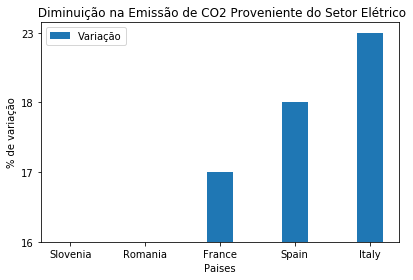

In [47]:
fig, ax = plt.subplots()
index = np.arange(len(valor))
bar_width = 0.35

rects1 = plt.bar(index, valor, bar_width, label='Variação')

plt.xlabel('Paises')
plt.ylabel('% de variação')
plt.title(' Diminuição na Emissão de CO2 Proveniente do Setor Elétrico')
plt.xticks(index, paises)
plt.legend()

plt.tight_layout()
plt.show()